In [55]:
! pip install kaggle

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [56]:
! mkdir ~/.kaggle

mkdir: /Users/viviana/.kaggle: File exists


In [57]:
! cp kaggle.json ~/.kaggle/

cp: kaggle.json: No such file or directory


In [58]:
! chmod 600 ~/.kaggle/kaggle.json

In [59]:
! kaggle datasets download kongaevans/speaker-recognition-dataset

speaker-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
# ! unzip speaker-recognition-dataset.zip

In [61]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.decomposition import PCA

In [62]:
a,sr = librosa.load('./16000_pcm_speeches/_background_noise_/doing_the_dishes.wav',sr=None)
sr

22050

In [63]:

audios = ['./16000_pcm_speeches/Benjamin_Netanyau', 
              './16000_pcm_speeches/Jens_Stoltenberg',
              './16000_pcm_speeches/Julia_Gillard',
              './16000_pcm_speeches/Magaret_Tarcher',
              './16000_pcm_speeches/Nelson_Mandela']
noises = ['./16000_pcm_speeches/_background_noise_',
              './16000_pcm_speeches/other']

audio_le = LE()
audios_labels = audio_le.fit_transform(audios)
noise_le = LE()
noises_labels = noise_le.fit_transform(noises)

In [64]:
audio_df = pd.DataFrame({'paths':audios})
sr = 16_000
audio_df['audios'] = audio_df['paths'].apply(lambda x: 
    [librosa.load(os.path.join(x,f),sr=sr)[0] for f in os.listdir(x)]                                            
)
noise_df = pd.DataFrame({'paths':noises})
noise_df['audios'] = noise_df['paths'].apply(lambda x: 
    [librosa.load(os.path.join(x,f),sr=sr)[0] for f in os.listdir(x)]                                            
)
audio_df['labels'] = audio_le.transform(audio_df['paths'])
noise_df['labels'] = noise_le.transform(noise_df['paths'])

In [65]:
print("Audio class size",list(audio_df['audios'].apply(len)))
print("Average audio length",list(audio_df['audios'].apply(lambda x: np.mean([len(y)/sr for y in x]))))
print("Noise class size",list(noise_df['audios'].apply(len)))
print("Average noise length",np.mean(noise_df['audios'].apply(lambda x: np.mean([len(y)/sr for y in x]))))

Audio class size [1500, 1500, 1501, 1500, 1500]
Average audio length [1.0, 1.0, 1.0, 1.0, 1.0]
Noise class size [4, 2]
Average noise length 59.618156250000006


In [66]:
concat_noise = []
for i in range(len(noise_df)):
    concat_noise.extend(np.concatenate(noise_df['audios'].iloc[i]))
concat_noise = np.array(concat_noise)
print("Concatenated noise shape",concat_noise.shape)
chunk_len = sr
chunked_noise = []
for i in range(0,len(concat_noise)-chunk_len,chunk_len):
    chunked_noise.append(concat_noise[i:i+chunk_len])
chunked_noise = np.array(chunked_noise)
print("Noise shape",chunked_noise.shape)



Concatenated noise shape (5691061,)
Noise shape (355, 16000)


In [67]:
X = []
y = []
for i in range(len(audio_df)):
    for j in range(len(audio_df['audios'].iloc[i])):
        X.append(audio_df['audios'].iloc[i][j])
        y.append(audio_df['labels'].iloc[i])

In [68]:
aug_len = len(X)//5
n = len(X)
for _ in range(aug_len):
    i = np.random.randint(n)
    j = np.random.randint(len(chunked_noise))
    check = np.random.rand() 
    if check < 0.35:
        aug_X = X[i] + 0.25*chunked_noise[j]
    elif check < 0.6:
        aug_X = X[i]*chunked_noise[j]
    else:
        k = np.random.randint(n)
        aug_X = X[i] + 0.25*X[k]
    X.append(aug_X)
    y.append(y[i])

X = np.array(X)
y = np.array(y)   

In [69]:
print("X (Audio) shape",X.shape)
print("y (label) shape",y.shape)

X (Audio) shape (9001, 16000)
y (label) shape (9001,)


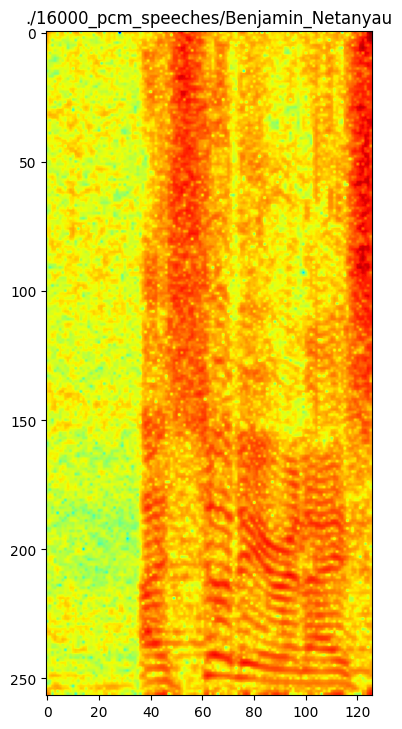

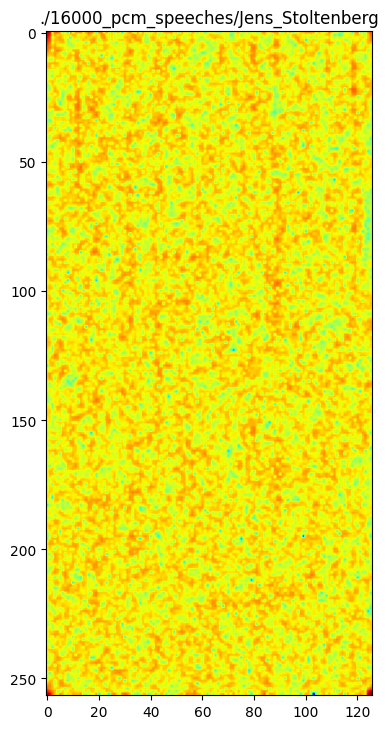

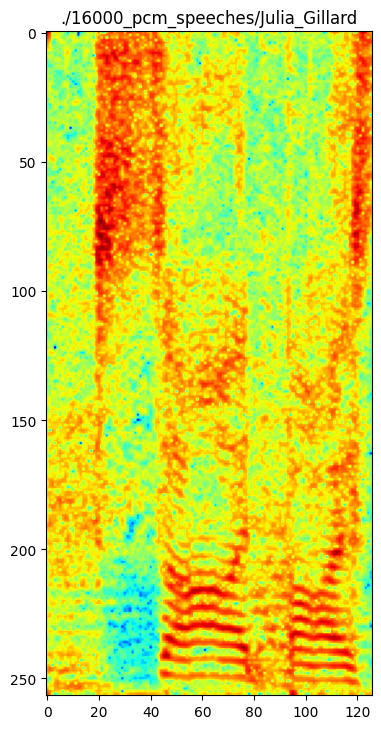

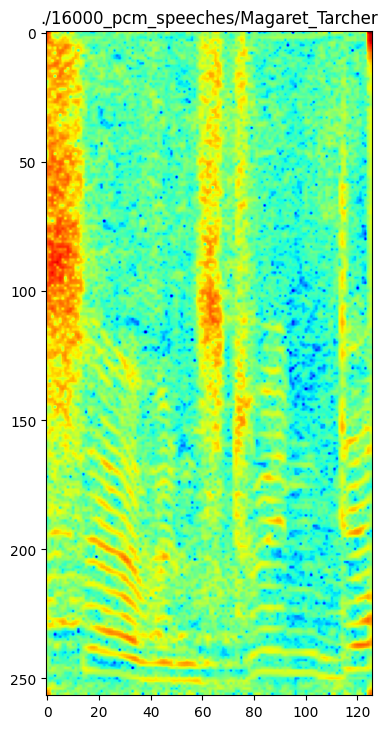

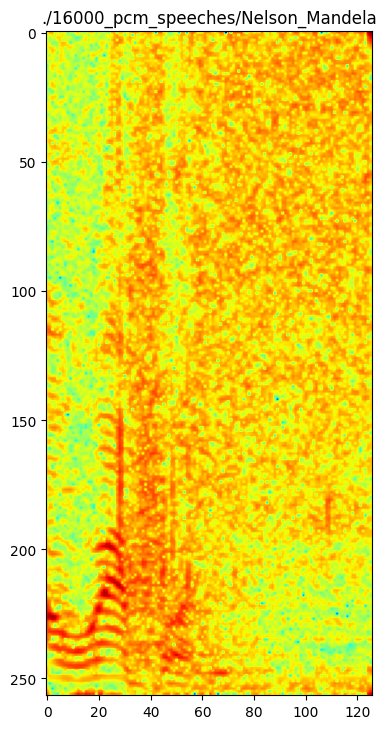

In [70]:

for s in range(max(y)+1):
    plt.figure(figsize=(50,50))
    plt.subplot(max(y)+1,1,s+1)
    speakers = X[y==s]
    spek = speakers[np.random.randint(len(speakers))]
    stft_X = np.abs(librosa.stft(y=spek,n_fft=512))**2
    stft_X = np.flip(stft_X,axis=0)
    plt.imshow(np.log(stft_X) - np.log(stft_X).mean(axis=-1,keepdims=True),cmap='jet')
    plt.title(audio_le.inverse_transform([s])[0])

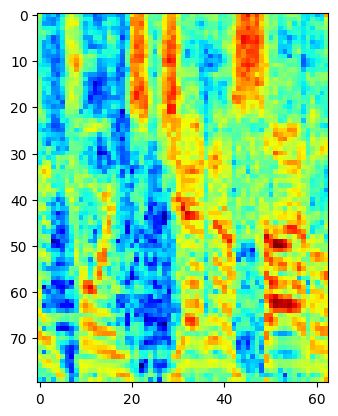

In [71]:
spec_X = librosa.feature.melspectrogram(y=X[0],sr=sr,n_fft=512,hop_length=256,n_mels=80)
spec_X = np.flip(spec_X,axis=0)
plt.imshow(np.log(spec_X+1e-7)-np.log(spec_X+1e-7).mean(axis=-1,keepdims=True),cmap='jet')
plt.show()

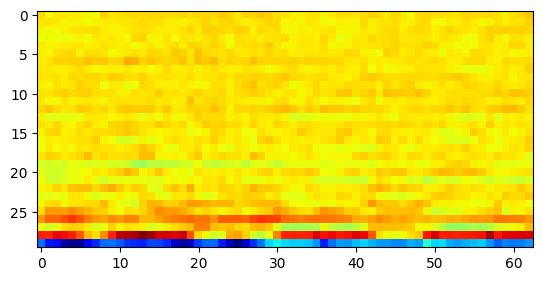

In [72]:
mfcc_X = librosa.feature.mfcc(y=X[0],sr=sr,n_fft=512,hop_length=256,n_mfcc=30)
mfcc_X = np.flip(mfcc_X,axis=0)
plt.imshow(mfcc_X, cmap='jet')
plt.show()

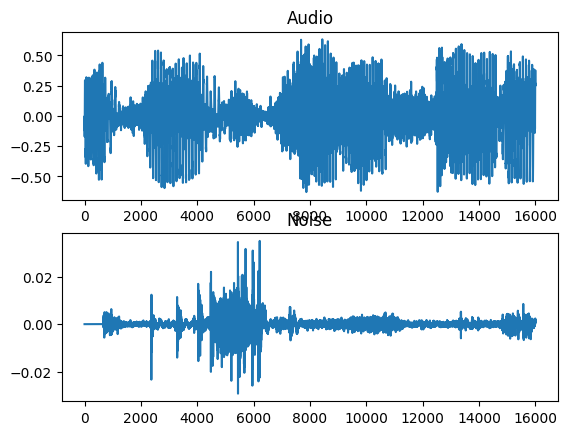

In [73]:
plt.subplot(2,1,1)
plt.plot(np.arange(sr),X[0])
plt.title("Audio")
plt.subplot(2,1,2)
plt.plot(np.arange(chunk_len),chunked_noise[0])
plt.title("Noise")
plt.show()

In [74]:
mfccs = librosa.feature.mfcc(y=X,sr=sr,n_fft=400,hop_length=160,n_mfcc=20)
deltas = librosa.feature.delta(mfccs)
deltas_2 = librosa.feature.delta(mfccs,order=2)
lpcs = []
for i in range(len(X)):
    lpcs.append(librosa.lpc(X[i],12))
lpcs = np.array(lpcs)

/var/folders/wq/h98lxdbn1t9fq7bt3sl45jtc0000gn/T/ipykernel_10183/1507664088.py:6: FutureWarning: Pass order=12 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  lpcs.append(librosa.lpc(X[i],12))


In [75]:
num_bins = 10
ldb_features = []
for audio in X:
    stft = np.abs(librosa.stft(audio))
    log_bins = librosa.core.fft_frequencies(sr=sr, n_fft=stft.shape[0])
    log_bins = librosa.core.hz_to_mel(log_bins)
    log_bins = np.logspace(np.log10(log_bins[0]), np.log10(log_bins[-1]), num_bins)
    ldb_feature = np.zeros(num_bins - 1)
    for i in range(num_bins - 1):
        freq_range = np.where((log_bins[i] <= librosa.core.mel_frequencies(n_mels=stft.shape[0], fmin=0, fmax=sr)) &
                              (librosa.core.mel_frequencies(n_mels=stft.shape[0], fmin=0, fmax=sr) <= log_bins[i + 1]))
        ldb_feature[i] = np.sum(stft[freq_range])
    ldb_features.append(ldb_feature)
    ldb = np.array(ldb_features)

/var/folders/wq/h98lxdbn1t9fq7bt3sl45jtc0000gn/T/ipykernel_10183/3414310660.py:7: RuntimeWarning: divide by zero encountered in log10
  log_bins = np.logspace(np.log10(log_bins[0]), np.log10(log_bins[-1]), num_bins)
/opt/homebrew/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/homebrew/lib/python3.9/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


In [76]:
mfccs = mfccs.reshape(mfccs.shape[0],-1)
deltas = deltas.reshape(deltas.shape[0],-1)
deltas_2 = deltas_2.reshape(deltas_2.shape[0],-1)
lpcs = lpcs.reshape(lpcs.shape[0],-1)

In [77]:
X = np.concatenate((deltas,mfccs,deltas_2),axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

num_components = 100
from sklearn.decomposition import PCA
pca = PCA(n_components=num_components)
X = pca.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42)

In [78]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=0.001,random_state=42,dual='auto')
clf.fit(X_train,y_train)
print("Train accuracy",clf.score(X_train,y_train))
print("Test accuracy",clf.score(X_test,y_test))

Train accuracy 0.9044444444444445
Test accuracy 0.9259807549962991


In [79]:
from sklearn.mixture import GaussianMixture as GMM

#make 1 gmm for all 5 classes
models = []
for i in range(5):
    gmm = GMM(n_components=2,covariance_type='diag',random_state=42)
    gmm.fit(X_train[y_train==i])
    models.append(gmm)

#predict
y_pred = np.zeros_like(y_test)
for i in range(len(X_test)):
    scores = [m.score(X_test[i].reshape(1,-1)) for m in models]
    y_pred[i] = np.argmax(scores)

from sklearn.metrics import accuracy_score
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.8874907475943745


In [80]:
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f) 